In [1]:
using FileIO, JLD2;
using Plots, Random, LinearAlgebra, Printf, StatsBase, Random;
using DifferentialEquations, DynamicalSystems, Statistics;
using BenchmarkTools, ProgressMeter;

In [2]:
@load "../y-o.jld2"
@load "../y-t.jld2"

1-element Vector{Symbol}:
 :dat

In [3]:
varinfo()

| name         |        size | summary                 |
|:------------ | -----------:|:----------------------- |
| Base         |             | Module                  |
| Core         |             | Module                  |
| Main         |             | Module                  |
| dat          | 456.914 KiB | 40×1462 Matrix{Float64} |
| observed_dat | 456.914 KiB | 40×1462 Matrix{Float64} |


# algo

In [4]:
# struct StateSpace
#     x_a::Vector{Float64}
#     p_a::AbstractMatrix
# end

struct StateSpace
    x_a::Matrix{Float64}
end

struct StateSpace_Pf
    x_a::Matrix{Float64}
    p_f::Matrix{Float64}
end

In [5]:
function L96(x::Vector{Float64}, F::Float64)
    N = length(x) 
    # Setting up vector
    dx = zeros(Float64, N)
    # 3 edge cases explicitly (performance)
    @inbounds dx[1] = (x[2] - x[N - 1]) * x[N] - x[1] + F
    @inbounds dx[2] = (x[3] - x[N]) * x[1] - x[2] + F
    @inbounds dx[N] = (x[1] - x[N - 2]) * x[N - 1] - x[N] + F
    # then the general case
    for n in 3:(N - 1)
      @inbounds dx[n] = (x[n + 1] - x[n - 2]) * x[n - 1] - x[n] + F
    end
    return dx
end

L96 (generic function with 1 method)

In [6]:
function RunK4(x::Vector{Float64}, dt::Float64, F::Float64)
    k1 = L96(x, F)
    x1 = x + k1 * dt/2
    k2 = L96(x1, F)
    x2 = x + k2 * dt/2
    k3 = L96(x2, F)
    x3 = x + k3 * dt
    k4 = L96(x3, F)
    return x + (k1 + 2k2 + 2k3 + k4) * dt / 6
end

RunK4 (generic function with 1 method)

In [7]:
# function TLM(delta::Float64, x_a::Vector{Float64}, dt::Float64, F::Float64)
#     N= length(x_a)
#     tangentM = zeros(Float64, (N, N))
#     for i in 1:N
#         e_i = zeros(Float64, N)
#         e_i[i] = 1
#         tangentM[:, i] = (RunK4(x_a + delta * e_i, dt, F) - RunK4(x_a, dt, F)) / delta
#     end
#     return tangentM
# end

In [8]:
# function one_shotKF(state::StateSpace, y_o::Vector{Float64}, alpha::Float64, delta::Float64,
#         dt::Float64, N::Int64, H::AbstractMatrix, R::AbstractMatrix, F::Float64)
#     M = TLM(delta, state.x_a, dt, F)
#     x_f = RunK4(state.x_a, dt, 8.0)
#     P_f = M * state.p_a * transpose(M)
#     P_f = P_f * alpha
#     K = P_f * transpose(H) * inv(H * P_f * transpose(H) + R)
#     x_a = x_f + K * (y_o - H * x_f)
#     P_a = P_f - K * H * P_f
#     return x_a, P_a
# end

function one_shotKF(m::Int64, state::StateSpace, y_o::Vector{Float64}, alpha::Float64, delta::Float64,
        dt::Float64, N::Int64, H::AbstractMatrix, R::AbstractMatrix, F::Float64)
    dX_f = zeros(Float64, (N, m))
    x_aa = zeros(Float64, (N, m))
    x_f = zeros(Float64, (N, m))
    for i in 1:m
        x_f[:, i] += RunK4(state.x_a[:, i], dt, 8.0)
    end
    x_bar = mean(x_f, dims=2)

    for i in 1:m
        dX_f[:, i] += (x_f[:, i] - x_bar) * (1. + alpha)
    end
#     dY_f = H * dX_f
        
    P_f = dX_f * transpose(dX_f) / (m - 1)
#     K = P_f * transpose(H) * inv(H * P_f * transpose(H) + R)
    K = P_f * inv(P_f + R)
#     P_a = (I(40) - K * H) * P_f * transpose((I(40) - K * H))
    for j in 1:m
        e_o = randn(Float64, N)
#         x_aa[:, j] += x_f[:, j] + K * (y_o + e_o - H * x_f[:, j])
        x_aa[:, j] += x_f[:, j] + K * (y_o + e_o - x_f[:, j])
    end
    return x_aa, P_f
end

one_shotKF (generic function with 1 method)

In [9]:
const _N = 40
const _F = 8.0
const _dt = 0.05
const _delta = 1e-8
rng = MersenneTwister(1234);

In [10]:
@time begin
    m = 100
    _alpha = 0.
    J = I(_N)
    # choose ensamble samples in an atractor(observed_dat) with small noise addition
    sampling = sample(rng, collect(1:size(observed_dat)[2]), m, replace=false)
    x_a = observed_dat[:, sampling]
    x_a += randn(rng, Float64, (_N, m))
    state = StateSpace(x_a)
    state_pf = StateSpace_Pf(x_a, J)

    # KF simulation
    x_analyze = zeros(Float64, (size(dat)))
    x_analyze[:, 1] = observed_dat[:, 1]
    p_f_all_100 = zeros(Float64, (size(dat)[2], _N, _N))
    p_f_all_100[1, :, :] = J
    for i in 2:size(dat)[2]
        y_o = observed_dat[:, i]
        x_a, p_f = one_shotKF(m, state, y_o, _alpha, _delta, _dt, _N, J, J, _F)

        state = StateSpace(x_a)
        # take the mean of emsambles. -> the analyzed value
        x_analyze[:, i] = mean(x_a, dims=2)
        p_f_all_100[i, :, :] += p_f
    end
end

  6.633922 seconds (12.18 M allocations: 2.584 GiB, 11.38% gc time, 70.86% compilation time)


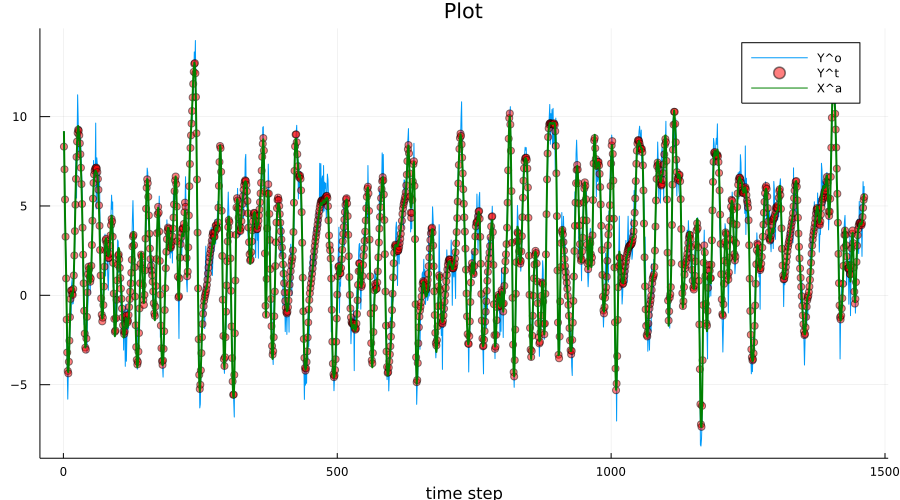

In [69]:
plot(observed_dat[1, :], title = "Plot", label = "Y^o", lw = 1, size = (900, 500))
plot!(dat[1, :], seriestype = :scatter, label="Y^t", markeralpha=0.5, color=:red)
plot!(x_analyze[1, :], label = "X^a", lw = 2, color=:green)
# plot!(x_test[1, :], label = "X^a", lw = 2, color=:green)
# plot(observed_dat[1, 1000:end], title = "Plot", label = "Y^o", lw = 1, size = (900, 500))
# plot!(dat[1, 1000:end], seriestype = :scatter, label="Y^t", markeralpha=0.5, color=:red)
# plot!(x_analyze[1, 1000:end], seriestype = :scatter, label="Y^t", markeralpha=0.5, color=:red)
# plot!(x_analyze[1, 1000:end], label = "X^a", lw = 2, color=:green)
xlabel!("time step")

In [70]:
function RMSE(x::Matrix{Float64}, dat::Matrix{Float64})
    l2dis = zeros(Float64, size(dat)[2])
    for i in 1:size(dat)[2]
        l2dis[i] = rmsd(x[:, i], dat[:, i])
    end
    return l2dis
end

RMSE (generic function with 1 method)

In [72]:
rmse_s = RMSE(x_analyze, dat)
@printf "%f" mean(rmse_s)
rmse_fig = plot(rmse_s , title = "Plot", label = "RMSE", lw = 1, size = (900, 500))
savefig(rmse_fig,"m100_rmse_with_inflation.png")

0.220957

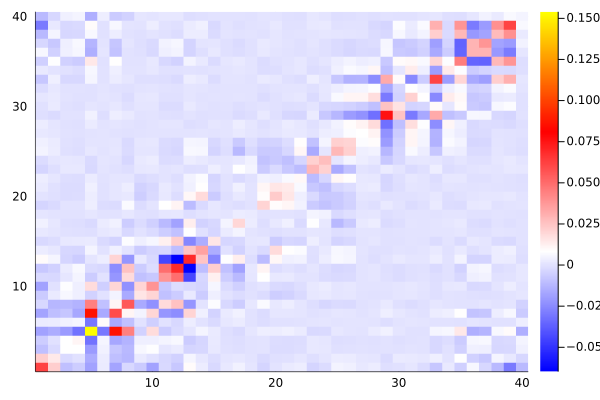

In [40]:
heatmap(p_f_all[900, :, :], c=cgrad([:blue, :white,:red, :yellow]))

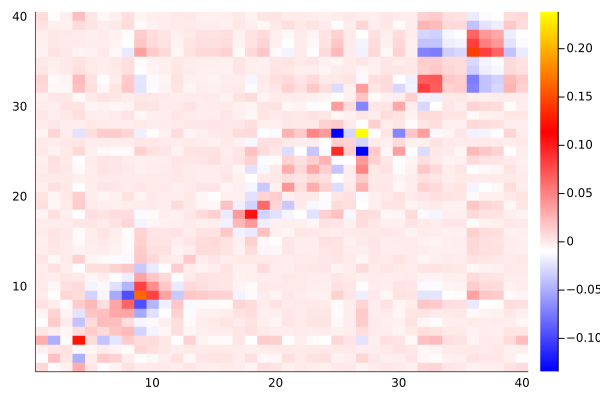

In [50]:
heatmap(p_f_all_100[1200, :, :], c=cgrad([:blue, :white,:red, :yellow]))

# covariance underestimation

## covariance inflation

In [18]:
len = 11
alpahs = LinRange(0., 1., len)
rmse_vec = zeros(Float64, len)
@showprogress for idx in 1:len
    m = 1000
    _alpha = alpahs[idx]
    J = I(_N)
    # choose ensamble samples in an atractor(observed_dat) with small noise addition
    sampling = sample(rng, collect(1:size(observed_dat)[2]), m, replace=false)
    x_a = observed_dat[:, sampling]
    x_a += randn(rng, Float64, (_N, m))
    state = StateSpace(x_a)

    # KF simulation
    x_analyze = zeros(Float64, (size(dat)))
    x_analyze[:, 1] = observed_dat[:, 1]
    for i in 2:size(dat)[2]
        y_o = observed_dat[:, i]
        x_a, p_f = one_shotKF(m, state, y_o, _alpha, _delta, _dt, _N, J, J, _F)

        state = StateSpace(x_a)
        # take the mean of emsambles. -> the analyzed value
        x_analyze[:, i] = mean(x_a, dims=2)
    end
    rmse_vec[idx] = mean(RMSE(x_analyze, dat))
end

Progress: 100%|█████████████████████████████████████████| Time: 0:02:36


In [21]:
len = 11
alpahs = LinRange(0., 1., len)
rmse_vec_10 = zeros(Float64, len)
@showprogress for idx in 1:len
    m = 10
    _alpha = alpahs[idx]
    J = I(_N)
    # choose ensamble samples in an atractor(observed_dat) with small noise addition
    sampling = sample(rng, collect(1:size(observed_dat)[2]), m, replace=false)
    x_a = observed_dat[:, sampling]
    x_a += randn(rng, Float64, (_N, m))
    state = StateSpace(x_a)

    # KF simulation
    x_analyze = zeros(Float64, (size(dat)))
    x_analyze[:, 1] = observed_dat[:, 1]
    for i in 2:size(dat)[2]
        y_o = observed_dat[:, i]
        x_a, p_f = one_shotKF(m, state, y_o, _alpha, _delta, _dt, _N, J, J, _F)

        state = StateSpace(x_a)
        # take the mean of emsambles. -> the analyzed value
        x_analyze[:, i] = mean(x_a, dims=2)
    end
    rmse_vec_10[idx] = mean(RMSE(x_analyze, dat))
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


In [56]:
len = 21
alpahs = LinRange(0.2, 0.4, len)
rmse_vec_100 = zeros(Float64, len)
@showprogress for idx in 1:len
    m = 100
    _alpha = alpahs[idx]
    J = I(_N)
    # choose ensamble samples in an atractor(observed_dat) with small noise addition
    sampling = sample(rng, collect(1:size(observed_dat)[2]), m, replace=false)
    x_a = observed_dat[:, sampling]
    x_a += randn(rng, Float64, (_N, m))
    state = StateSpace(x_a)

    # KF simulation
    x_analyze = zeros(Float64, (size(dat)))
    x_analyze[:, 1] = observed_dat[:, 1]
    for i in 2:size(dat)[2]
        y_o = observed_dat[:, i]
        x_a, p_f = one_shotKF(m, state, y_o, _alpha, _delta, _dt, _N, J, J, _F)

        state = StateSpace(x_a)
        # take the mean of emsambles. -> the analyzed value
        x_analyze[:, i] = mean(x_a, dims=2)
    end
    rmse_vec_100[idx] = mean(RMSE(x_analyze, dat))
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:38


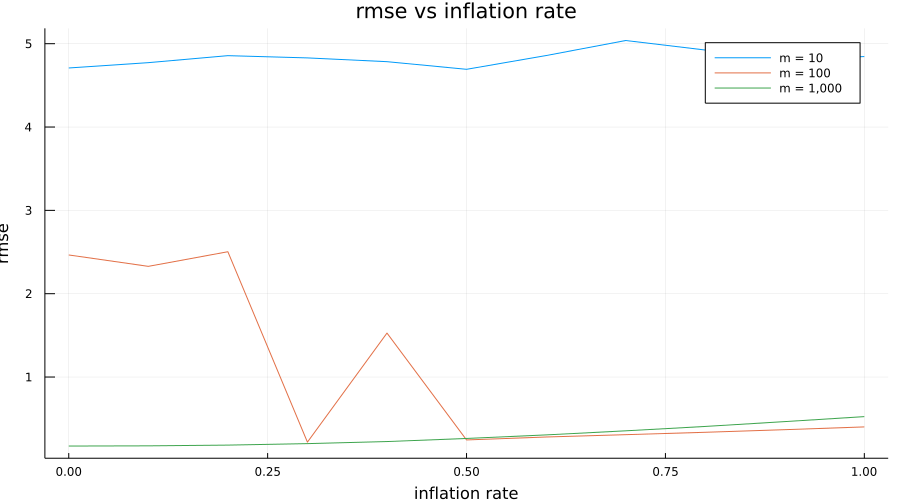

In [29]:
fig = plot(alpahs, rmse_vec_10, title="rmse vs inflation rate", label="m = 10", size=(900, 500))
plot!(alpahs, rmse_vec_100, label="m = 100")
plot!(alpahs, rmse_vec, label="m = 1,000")
ylabel!("rmse")
xlabel!("inflation rate")
# savefig(fig,"PO_inflation.png")

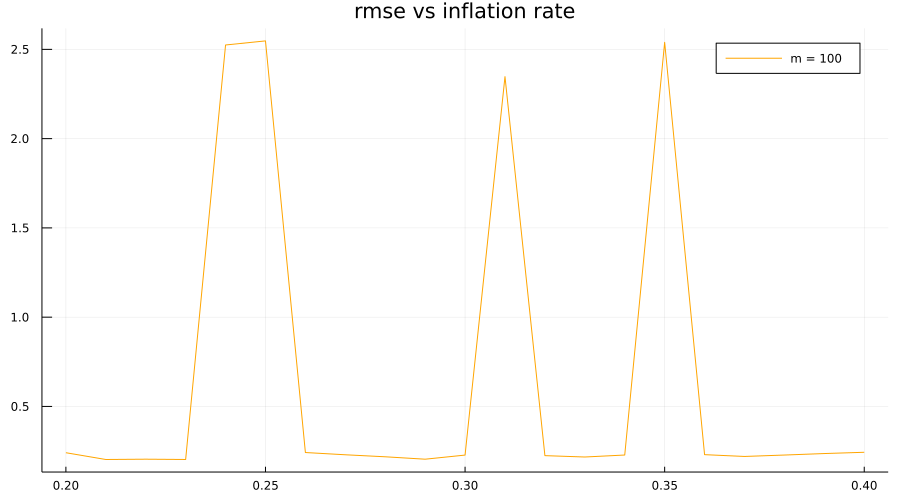

In [67]:
fig = plot(alpahs, rmse_vec_100, title="rmse vs inflation rate", label="m = 100", size=(900, 500), color=:orange)
# savefig(fig, "m100_002_004.png")

## parameter tune for rho

## locarization

In [ ]:
function gaspari_cohn(r)
#     if type(r) is float
#         ra = np.array([r])
#     else:
#         ra = r
    ra = np.abs(r)
    gp = np.zeros_like(ra)
    i=np.where(ra<=1.)[0]
    gp[i]=-0.25*ra[i]^5+0.5*ra[i]^4+0.625*ra[i]^3-5./3.*ra[i]^2+1.
    i=np.where((ra>1.)*(ra<=2.))[0]
    gp[i]=1./12.*ra[i]^5-0.5*ra[i]^4+0.625*ra[i]^3+5./3.*ra[i]^2-5.*ra[i]+4.-2./3./ra[i]
    if type(r) is float:
        gp = gp[0]
    return gp
end

In [51]:

len = 11
alpahs = LinRange(0., 1., len)

11-element LinRange{Float64}:
 0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0

In [54]:
len = 21
alpahs = LinRange(0.2, 0.4, len)

21-element LinRange{Float64}:
 0.2,0.21,0.22,0.23,0.24,0.25,0.26,0.27,…,0.34,0.35,0.36,0.37,0.38,0.39,0.4